In [1]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [15]:
data = pd.read_csv('data/Annual changes in global temperature 18801985.csv')
data.set_index('x').sort_index()

,Unnamed: 0
x,
-0.72,5
-0.54,6
-0.54,8
-0.49,14
-0.49,25
...,...
0.19,59
0.20,74
0.27,101


In [16]:
data.describe()

,Unnamed: 0,x
count,106.000000,106.000000
mean,53.500000,-0.120566
std,30.743563,0.217767
min,1.000000,-0.720000
25%,27.250000,-0.277500
50%,53.500000,-0.090000
75%,79.750000,0.040000
max,106.000000,0.420000


Отрисовка временного ряда

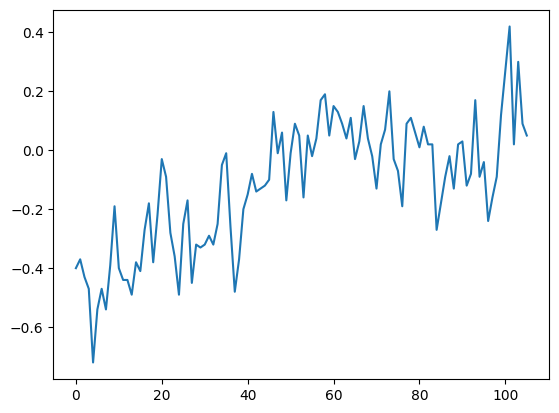

In [17]:
plt.plot(data['x'])

Стационарный процесс. Тест Дики-Фуллера

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def test_dfuller(ts, name):
    alpha = 0.05
    name = name

    # определяем временной ряд отдельной переменной
    ts = ts
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [20]:
test_dfuller(data['x'], 'Изменения температуры')

Тест Дики-Фуллера ряда Изменения температуры :
Test Statistic                 -1.909132
p-value                         0.327778
#Lags Used                      7.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


Декомпозиция ряда

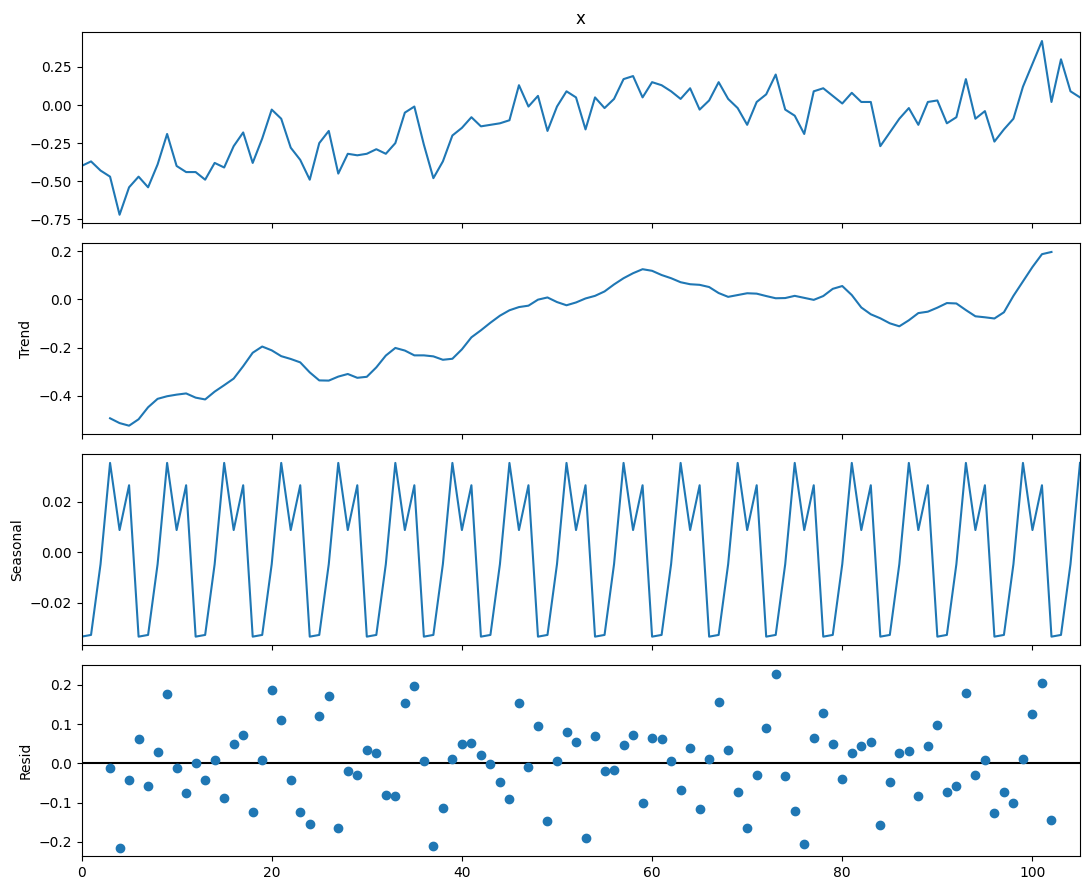

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams


rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(data['x'], 
                               period=6)
decompose.plot()
plt.show()

Дифференцирование ряда

In [22]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(1, len(data['x'])):
   nottrend.append(data['x'][i] - data['x'][i-1])

# выборка без сезонности
for i in range(s, len(data['x'])):
   notseason.append(data['x'][i] - data['x'][i-s])


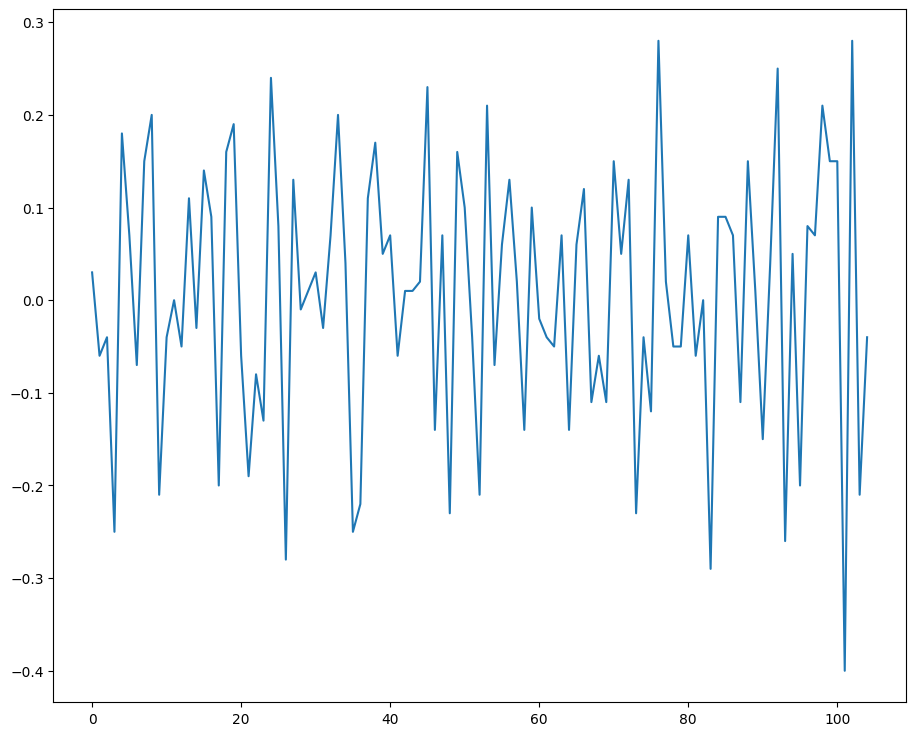

In [23]:
plt.plot(nottrend)

Тест Дики-Фуллера на временном ряде без тренда

In [24]:
test_dfuller(nottrend, 'Изменения температуры без тренда')

Тест Дики-Фуллера ряда Изменения температуры без тренда :
Test Statistic                -6.437287e+00
p-value                        1.640852e-08
#Lags Used                     6.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


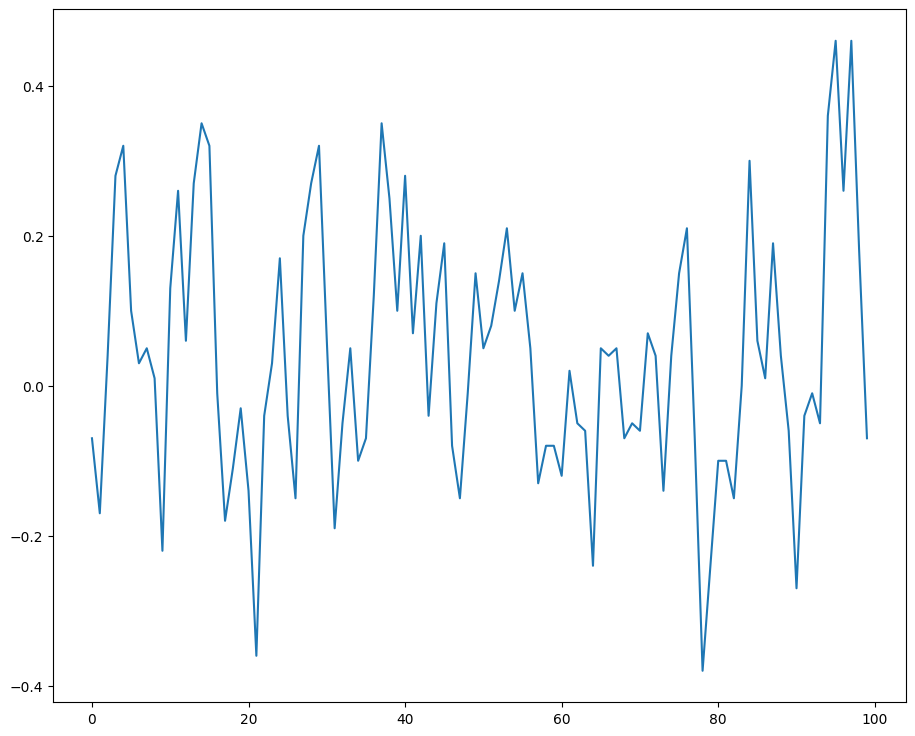

In [25]:
plt.plot(notseason)

Тест Дики-Фуллера на временном ряде без сезонности

In [26]:
test_dfuller(notseason, 'Изменения температуры без сезонности')

Тест Дики-Фуллера ряда Изменения температуры без сезонности :
Test Statistic                -5.681379e+00
p-value                        8.470794e-07
#Lags Used                     5.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Преобразование Бокса-Кокса

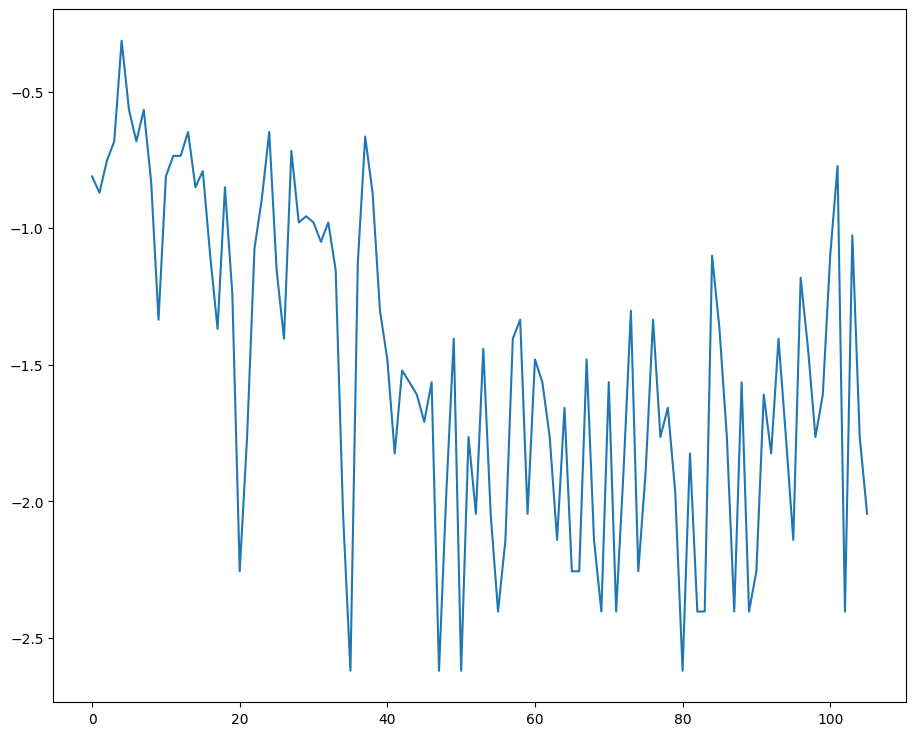

In [29]:
from scipy.stats import boxcox 


# выдал ошибку, что данные должны быть >= 0
# поэтому беру по модулю
transformed_data, best_lambda = boxcox(np.absolute(data['x'])) 

plt.plot(transformed_data) 

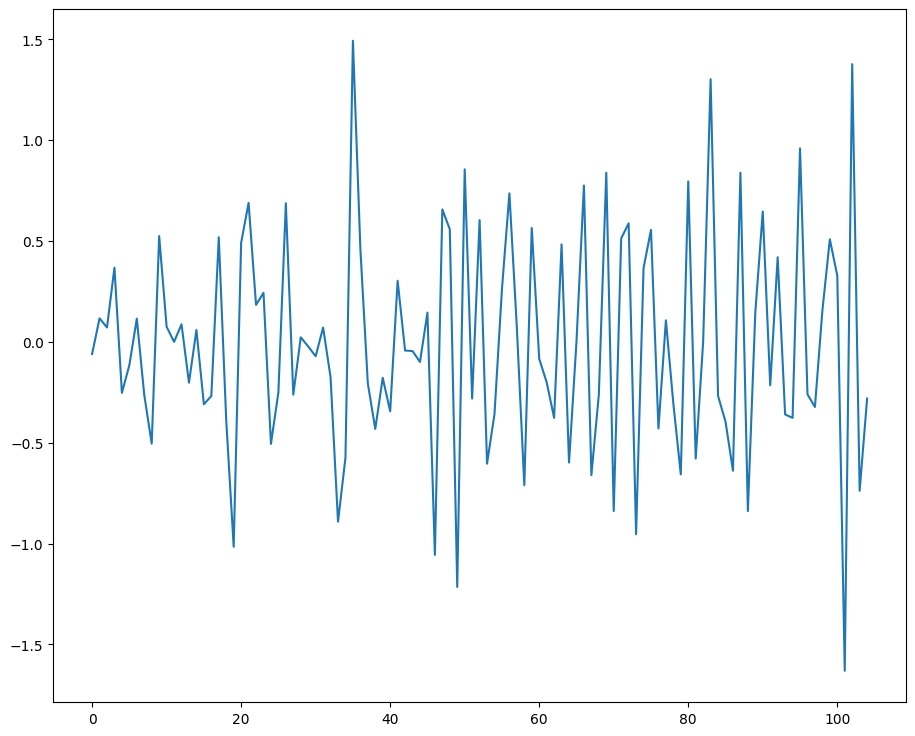

In [30]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 

In [31]:
# проверка на стационарность
test_dfuller(pnottrend, 'Изменения температуры после преобразования Бокса-Кокса')

Тест Дики-Фуллера ряда Изменения температуры после преобразования Бокса-Кокса :
Test Statistic                -8.448593e+00
p-value                        1.686263e-13
#Lags Used                     3.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Модели для предсказания значений временного ряда

Autoregression - модель, которая использует связь между наблюдением и некоторым количеством предыдущих наблюдений

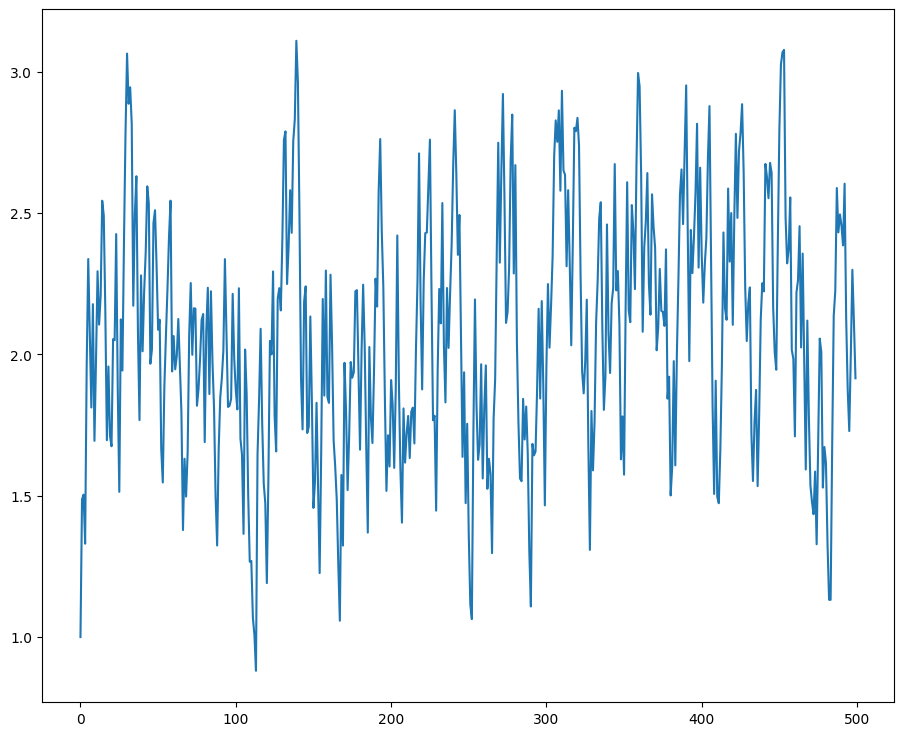

In [32]:
# AR(1)

N = 500

ar1 = [1]

for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())

plt.plot(ar1)

In [33]:
print(f"standart deviation = {np.std(ar1)}\n mean = {np.mean(ar1)}")

standart deviation = 0.4305540939602006
 mean = 2.070588103707329


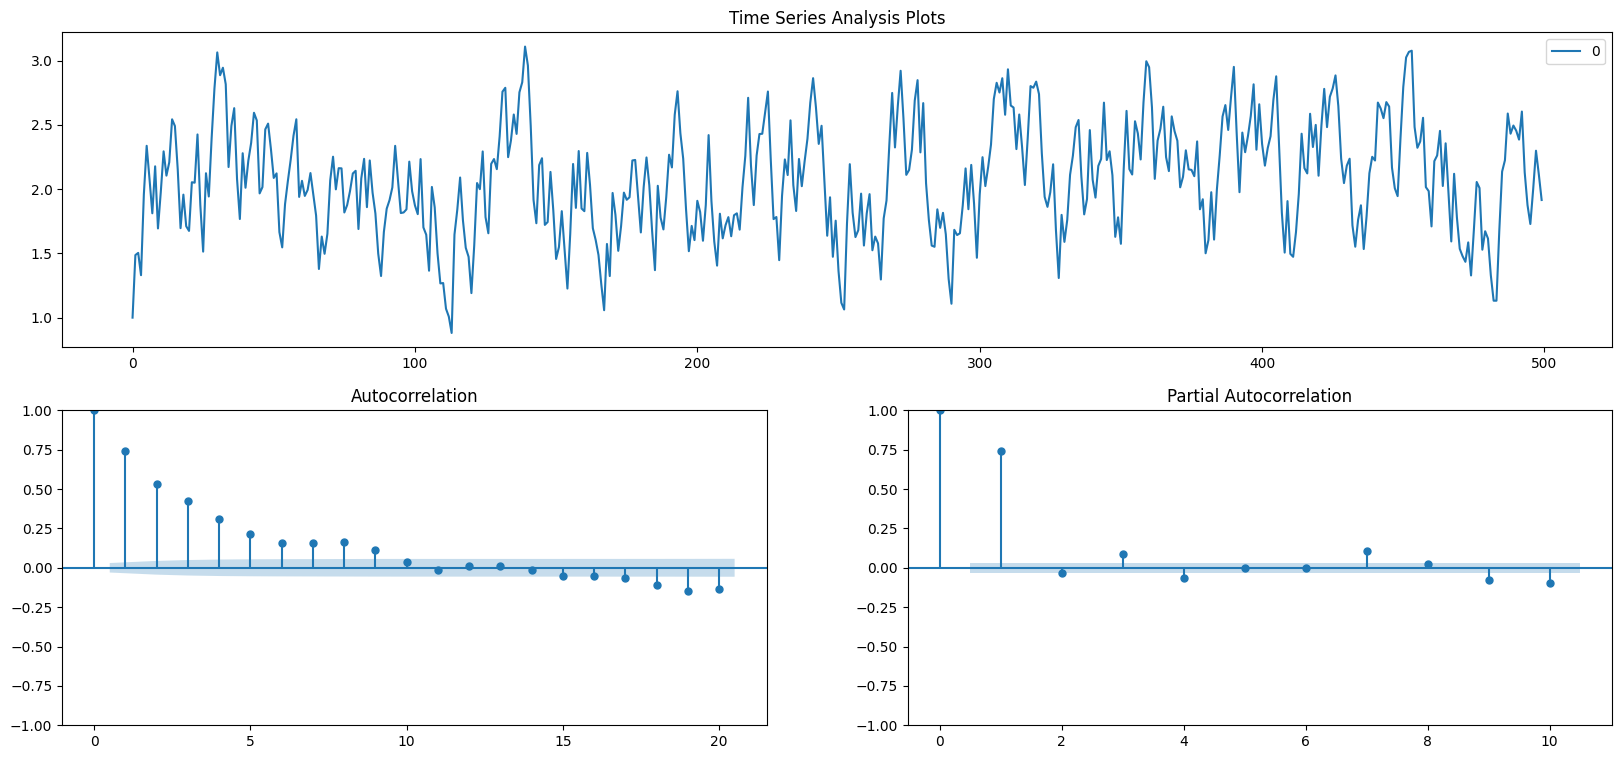

In [34]:
ts = pd.DataFrame(ar1)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

standart deviation = 0.47197977994034407
 mean = 0.2948931024146342


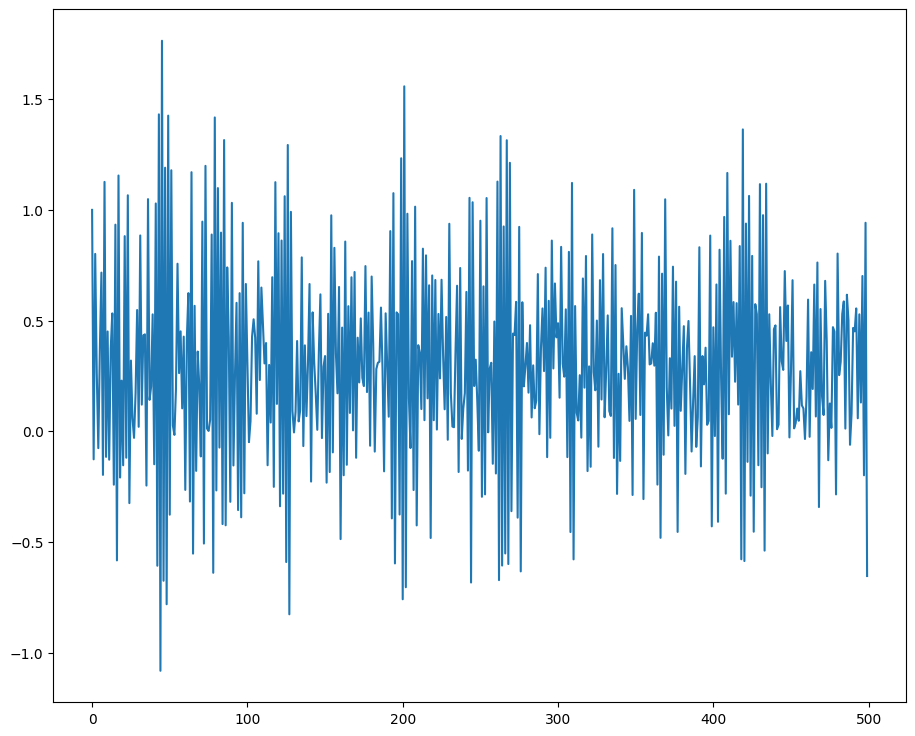

In [35]:
# AR(1)

N = 500

ar2 = [1]

for i in range(1, N):
    ar2.append(- 0.76*ar2[i-1] + np.random.random())

plt.plot(ar2)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

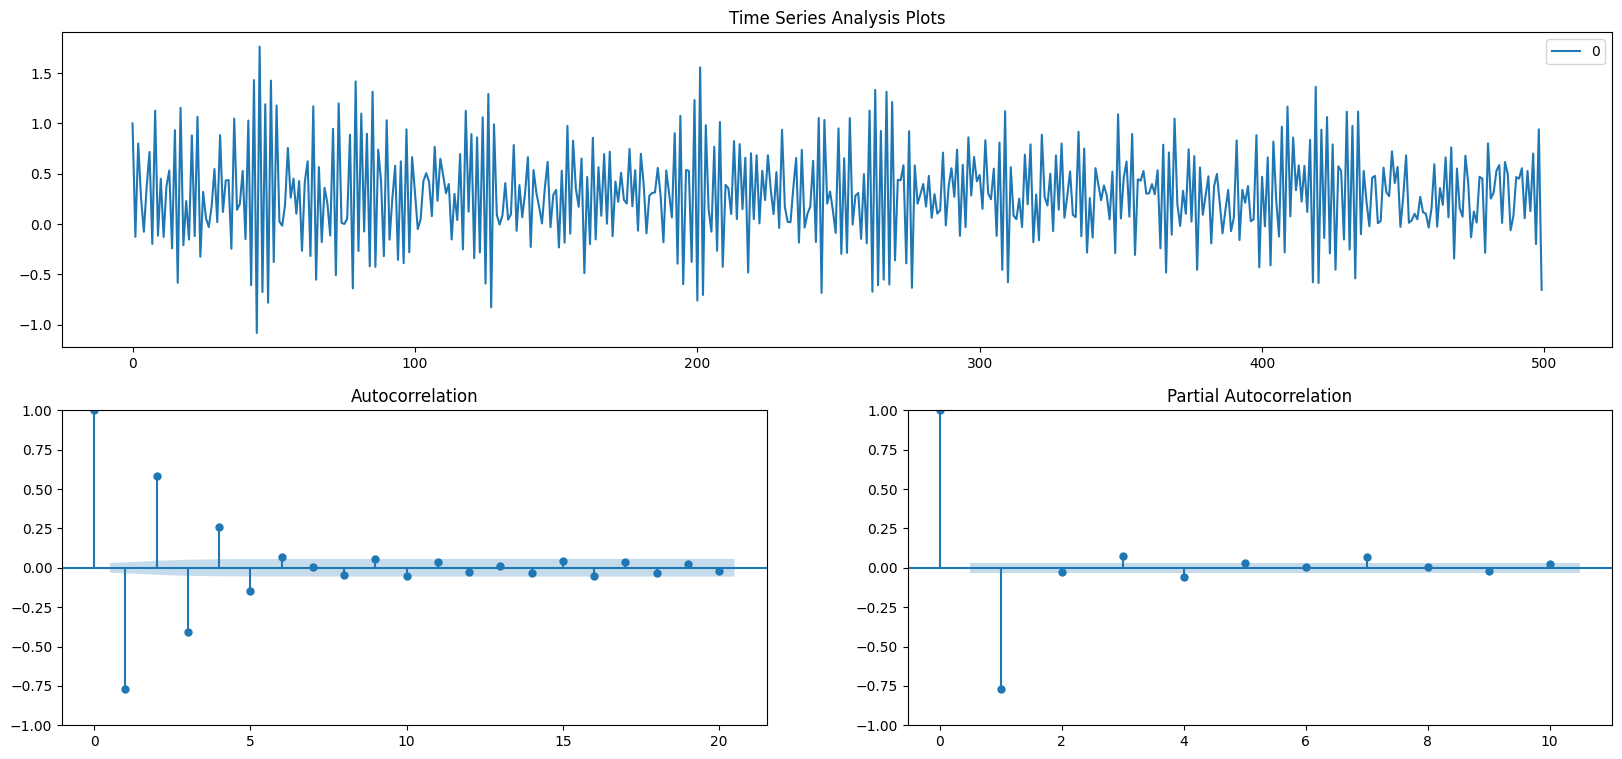

In [36]:
ts = pd.DataFrame(ar2)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

standart deviation = 0.47197977994034407
 mean = 0.2948931024146342


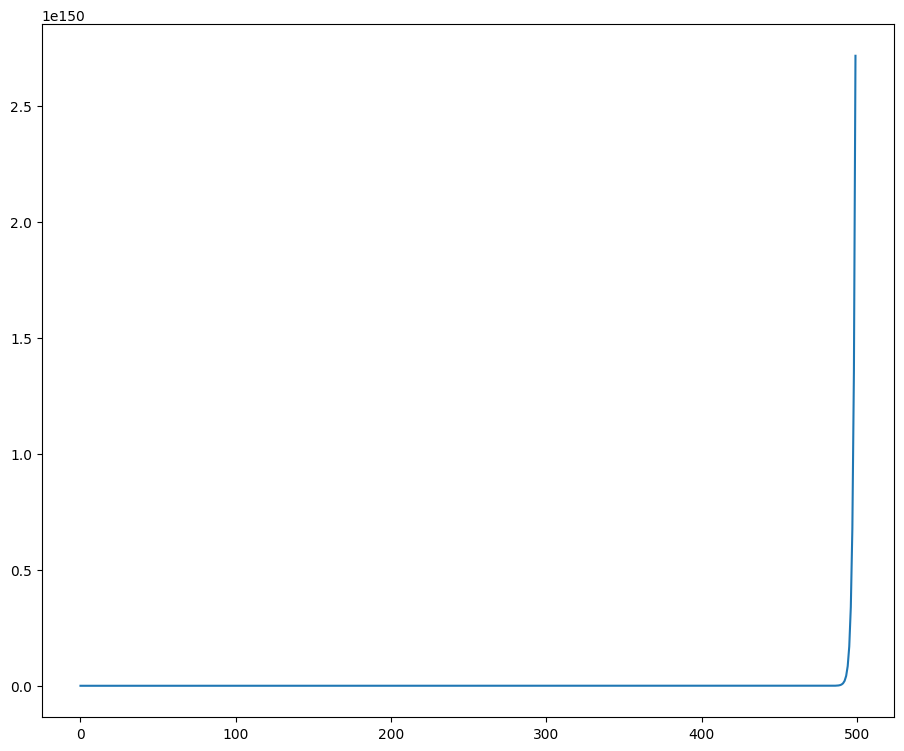

In [37]:
# AR(1)

N = 500

ar3 = [1]

for i in range(1, N):
    ar3.append(2 * ar3[i-1] + np.random.random())

plt.plot(ar3)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

In [42]:
data = pd.read_csv('data/Annual changes in global temperature 18801985.csv', names=['n','x'], skiprows=1)
data['t'] = data.index.values

ln = len(data)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = data[data['t'] <= train_cutoff]
validate_df = data[(data['t'] > train_cutoff) & (data['t'] <= validate_cutoff)]
forecast_df = data[data['t'] > validate_cutoff]

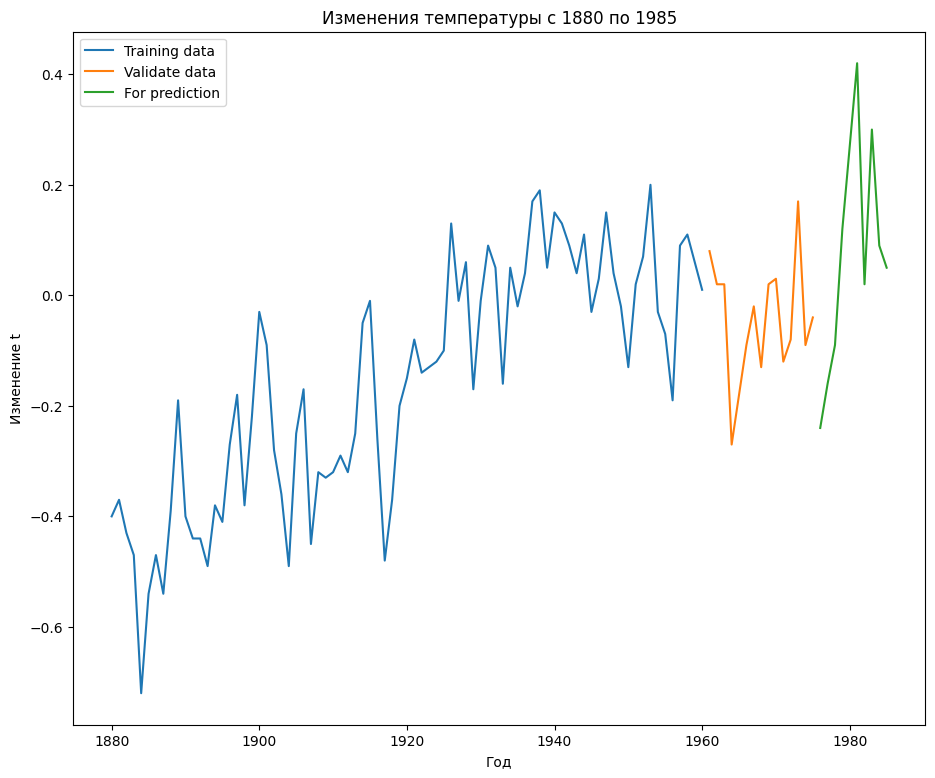

In [49]:
plt.plot(train_df.t + 1880, train_df.x, label='Training data')
plt.plot(validate_df.t + 1880, validate_df.x, label='Validate data')
plt.plot(forecast_df.t + 1880, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Изменения температуры с 1880 по 1985')
plt.ylabel('Изменение t')
plt.xlabel('Год')
plt.show()

In [50]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [51]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(data.t, 3, old_names=False)

res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  106
Model:                     AutoReg(3)   Log Likelihood                2897.057
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 08 Oct 2023   AIC                          -5784.114
Time:                        12:32:04   BIC                          -5770.941
Sample:                             3   HQIC                         -5778.779
                                  106                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   9.66e-15    6.9e+13      0.000       0.667       0.667
t.L1           1.0000   9.52e-15   1.05e+14      0.000       1.000       1.000
t.L2           0.3333   1.61e-16   2.07e+15      0.0

In [52]:
# тип ковариационной оценки - HC0
res = mod.fit(cov_type="HC0")

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  106
Model:                     AutoReg(3)   Log Likelihood                2897.057
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 08 Oct 2023   AIC                          -5784.114
Time:                        12:32:36   BIC                          -5770.941
Sample:                             3   HQIC                         -5778.779
                                  106                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   6.29e-15   1.06e+14      0.000       0.667       0.667
t.L1           1.0000   6.14e-15   1.63e+14      0.000       1.000       1.000
t.L2           0.3333   1.76e-16    1.9e+15      0.0

In [53]:
sel = ar_select_order(data.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  106
Model:                     AutoReg(1)   Log Likelihood                  62.436
Method:               Conditional MLE   S.D. of innovations              0.134
Date:                Sun, 08 Oct 2023   AIC                           -118.873
Time:                        12:33:04   BIC                           -110.911
Sample:                             1   HQIC                          -115.647
                                  106                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0223      0.015     -1.493      0.135      -0.052       0.007
x.L1           0.7822      0.060     13.035      0.000       0.665       0.900
                                    Roots           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


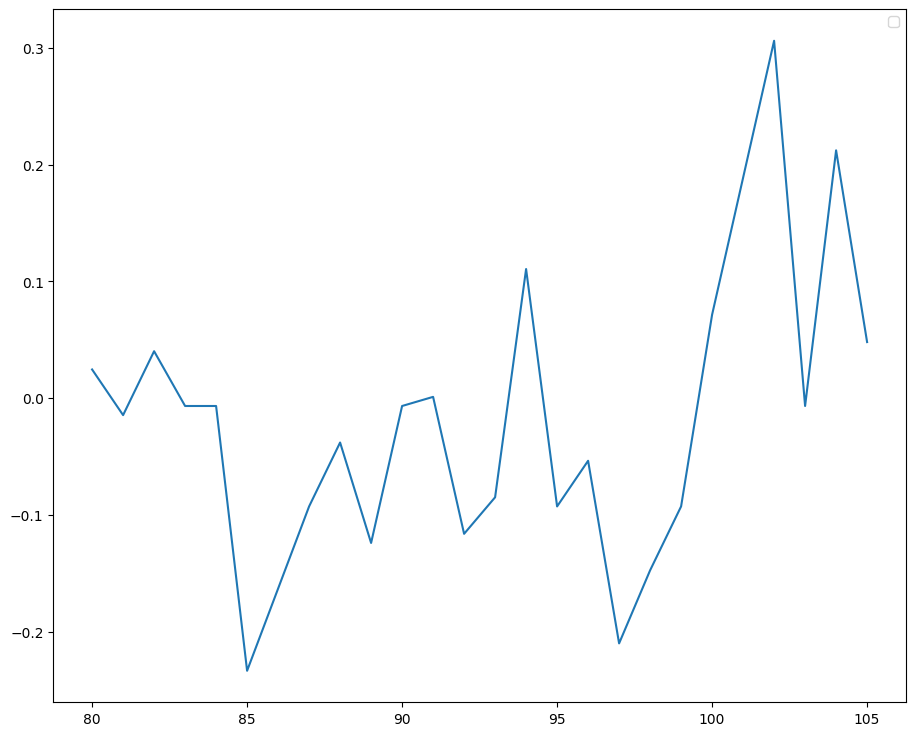

In [54]:
fig = res.plot_predict(train_cutoff)

Предсказанные временные ряды

In [56]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(data.t)-1]), dynamic=False)

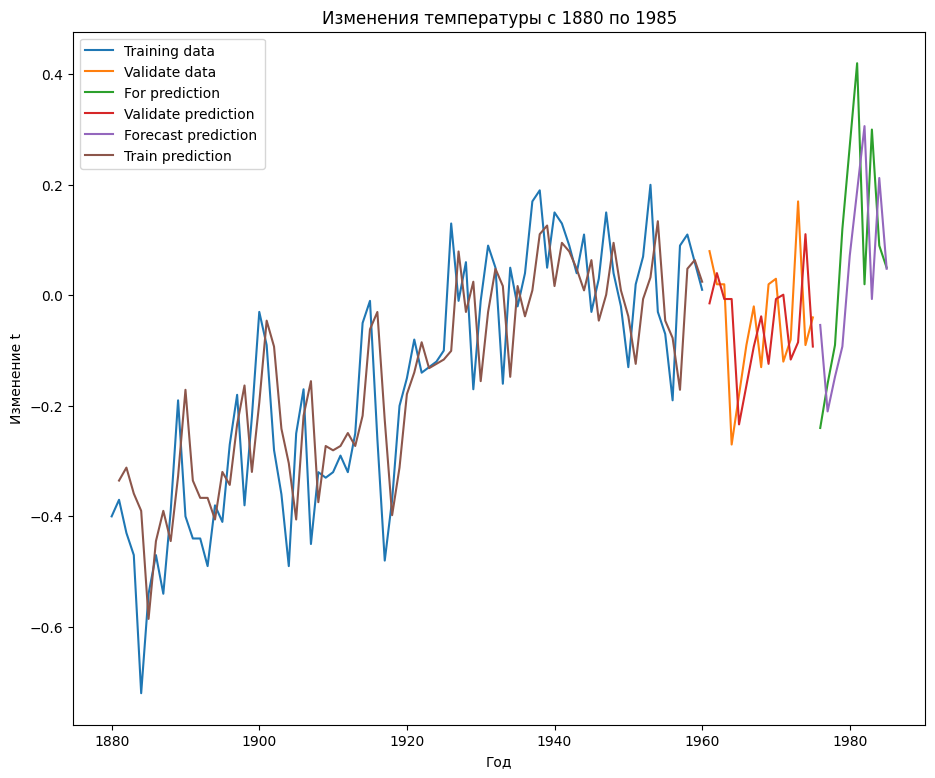

In [57]:
plt.plot(train_df.t + 1880, train_df.x, label='Training data')
plt.plot(validate_df.t + 1880, validate_df.x, label='Validate data')
plt.plot(forecast_df.t + 1880, forecast_df.x, label='For prediction')
plt.plot(validate_df.t + 1880, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t + 1880, f_pred, label='Forecast prediction')
plt.plot(train_df.t + 1880, pred, label='Train prediction')

plt.legend()
plt.title('Изменения температуры с 1880 по 1985')
plt.ylabel('Изменение t')
plt.xlabel('Год')
plt.show()

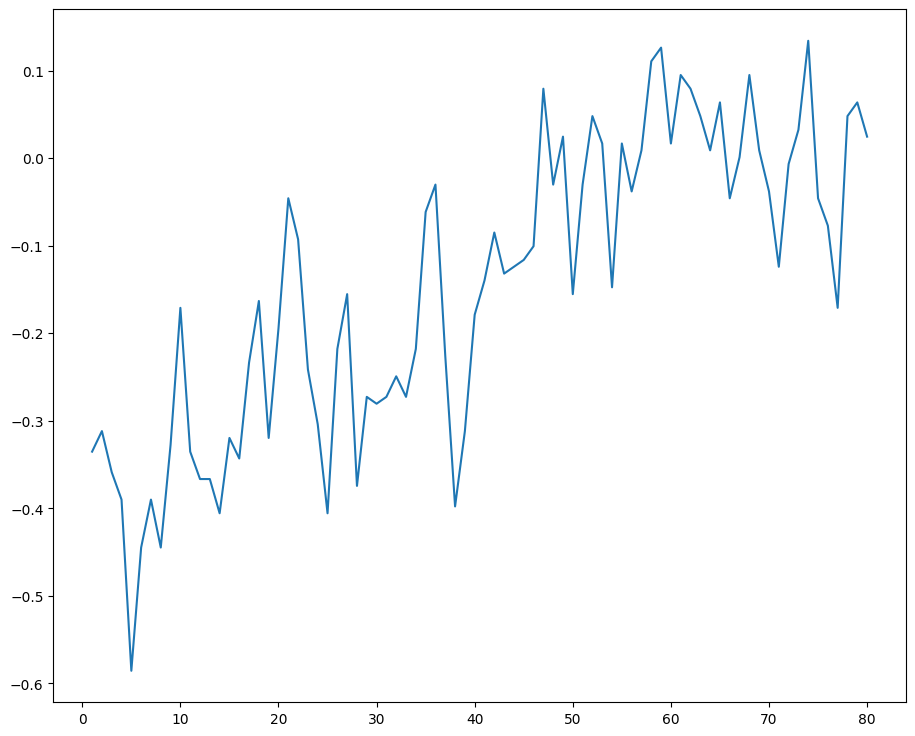

In [58]:
plt.plot(pred)

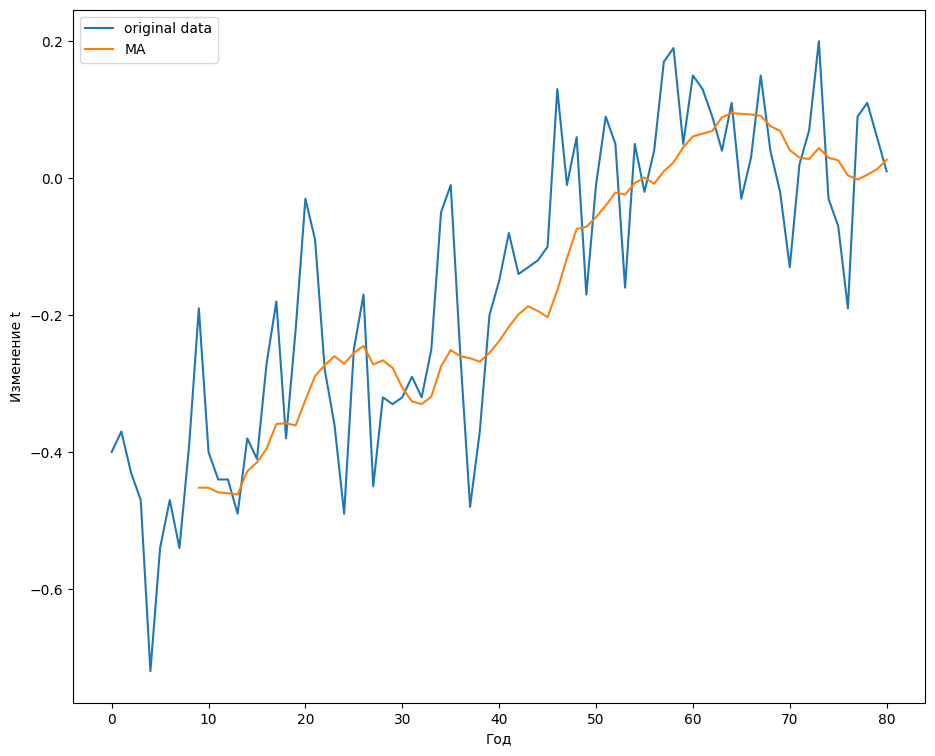

In [59]:
# MA

data['t'] = data.index.values

ln = len(data)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = data[data['t'] <= train_cutoff]
validate_df = data[(data['t'] > train_cutoff) & (data['t'] <= validate_cutoff)]
forecast_df = data[data['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Изменение t')
plt.xlabel('Год')
plt.show()

Метрики качества

In [60]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, sm

In [61]:
def smape(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

In [62]:
print("for AR model:")
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2:", r2_score(forecast_df.x, f_pred))
print("SMAPE:", smape(forecast_df.x, f_pred))

for AR model:
RMSE: 0.1922359156118508
MAPE: 2.1517177703476027
MAE: 0.16533906211760435
R2: 0.06481811794901737
SMAPE: 0.264
